<a href="https://colab.research.google.com/github/RodolfoFerro/dsc-tf/blob/main/notebooks/Clasificaci%C3%B3n%20de%20texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto básica

> **Nota:** El contenido de este cuaderno ha sido totalmente basado en la documentación oficial de [TensorFlow](https://www.tensorflow.org/tutorials/keras/text_classification?hl=es-419), sin embargo se han agregado algunos detalles extra para poder exportar datos y servirlos como modelo en un servicio.

Este tutorial demuestra la clasificación de texto a partir de archivos de texto sin formato almacenados en el disco. Entrenarás a un clasificador binario para realizar análisis de sentimientos en un conjunto de datos IMDB.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import shutil
import string
import os
import re

In [2]:

print(tf.__version__)

2.4.1


## Análisis de los sentimientos

Este cuaderno entrena un modelo de análisis de sentimientos para clasificar las reseñas de películas como positivas o negativas , según el texto de la reseña. Este es un ejemplo de clasificación binaria, o de dos clases, un tipo de problema de aprendizaje automático importante y ampliamente aplicable.

Utilizará el conjunto de datos de reseñas de películas ([Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)) que contiene el texto de 50.000 reseñas de películas del [Internet Movie Database](https://www.imdb.com/) (IMDB). Estos se dividen en 25,000 revisiones para capacitación y 25,000 revisiones para pruebas. Los conjuntos de entrenamiento y prueba están equilibrados , lo que significa que contienen un número igual de críticas positivas y negativas.


### Descargue y explore el conjunto de datos de IMDB

Descarguemos y extraigamos el conjunto de datos, luego exploremos la estructura del directorio.

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 6s 0us/step


In [4]:
os.listdir(dataset_dir)

['imdbEr.txt', 'train', 'imdb.vocab', 'test', 'README']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsupBow.feat',
 'pos',
 'urls_neg.txt',
 'unsup',
 'labeledBow.feat']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Cargar el conjunto de datos

A continuación, cargará los datos del disco y los preparará en un formato adecuado para el entrenamiento. Para hacerlo, utilizará la útil utilidad [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory), que espera una estructura de directorio de la siguiente manera.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

Para preparar un conjunto de datos para la clasificación binaria, necesitará dos carpetas en el disco, correspondientes a `class_a` Y `class_b`. Estas serán las críticas positivas y negativas de películas, que se pueden encontrar en `aclImdb/train/pos` y `aclImdb/train/neg`. Como el conjunto de datos de IMDB contiene carpetas adicionales, las eliminará antes de usar esta utilidad.

In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

A continuación, utilizará la utilidad `text_dataset_from_directory` para crear un `tf.data.Dataset` dataset etiquetado. [tf.data](https://www.tensorflow.org/guide/data) es una poderosa colección de herramientas para trabajar con datos.

Al ejecutar un experimento de aprendizaje automático, se recomienda dividir su conjunto de datos en tres divisiones: [entrenamiento](https://developers.google.com/machine-learning/glossary#training_set), [validación](https://developers.google.com/machine-learning/glossary#validation_set) y [prueba](https://developers.google.com/machine-learning/glossary#test-set).

El conjunto de datos de IMDB ya se ha dividido en entrenamiento y prueba, pero carece de un conjunto de validación. Creemos un conjunto de validación usando una división 80:20 de los datos de entrenamiento usando el argumento `validation_split` continuación.

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Como puede ver arriba, hay 25.000 ejemplos en la carpeta de formación, de los cuales utilizará el 80% (o 20.000) para la formación. Como verá en un momento, puede entrenar un modelo pasando un conjunto de datos directamente a `model.fit`. Si es nuevo en `tf.data`, también puede iterar sobre el conjunto de datos e imprimir algunos ejemplos de la siguiente manera.

In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Observe que las reseñas contienen texto sin formato (con puntuación y etiquetas HTML ocasionales como `<br/>` ). Mostrará cómo manejarlos en la siguiente sección.

Las etiquetas son 0 o 1. Para ver cuáles corresponden a reseñas de películas positivas y negativas, puede verificar la propiedad `class_names` en el conjunto de datos.

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


A continuación, creará un conjunto de datos de validación y prueba. Utilizará las 5.000 revisiones restantes del conjunto de formación para la validación.

> Nota: Cuando utilice los argumentos `validation_split` y `subset`, asegúrese de especificar una semilla aleatoria o de pasar `shuffle=False`, para que las divisiones de validación y entrenamiento no se superpongan.

In [11]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare el conjunto de datos para el entrenamiento

A continuación, estandarizará, tokenizará y vectorizará los datos utilizando la útil capa de `preprocessing.TextVectorization`.

La estandarización se refiere al preprocesamiento del texto, generalmente para eliminar la puntuación o elementos HTML para simplificar el conjunto de datos. La tokenización se refiere a dividir cadenas en tokens (por ejemplo, dividir una oración en palabras individuales, dividiéndola en espacios en blanco). La vectorización se refiere a convertir tokens en números para que se puedan alimentar a una red neuronal. Todas estas tareas se pueden realizar con esta capa.

Como vio anteriormente, las reseñas contienen varias etiquetas HTML como `<br />`. Estas etiquetas no serán eliminadas por el estandarizador predeterminado en la capa `TextVectorization` (que convierte el texto a minúsculas y elimina la puntuación por defecto, pero no elimina el HTML). Escribirás una función de estandarización personalizada para eliminar el HTML.



In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

A continuación, creará una capa `TextVectorization`. usará esta capa para estandarizar, tokenizar y vectorizar nuestros datos. Establece `output_mode` en `int` para crear índices enteros únicos para cada token.

Tenga en cuenta que está utilizando la función de división predeterminada y la función de estandarización personalizada que definió anteriormente. También podrá definir algunas constantes para el modelo, como un máximo explícita `sequence_length`, lo que hará que la capa de secuencias almohadilla o truncar a exactamente `sequence_length` valores.

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

A continuación, llamará a `adapt` para ajustar el estado de la capa de preprocesamiento al conjunto de datos. Esto hará que el modelo cree un índice de cadenas a números enteros.

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Creemos una función para ver el resultado de usar esta capa para preprocesar algunos datos.

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

Como puede ver arriba, cada token ha sido reemplazado por un número entero. Puede buscar el token (cadena) al que corresponde cada entero llamando a `.get_vocabulary()` en la capa.

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


Estás casi listo para entrenar tu modelo. Como paso final de preprocesamiento, aplicará la capa `TextVectorization` que creó anteriormente al conjunto de datos de entrenamiento, validación y prueba.

In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configurar el conjunto de datos para el rendimiento

Estos son dos métodos importantes que debe utilizar al cargar datos para asegurarse de que las E/S no se bloqueen.

`.cache()` mantiene los datos en la memoria después de que se cargan del disco. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede usar este método para crear una caché en disco de alto rendimiento, que es más eficiente de leer que muchos archivos pequeños.

`.prefetch()` superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento. 

Puede obtener más información sobre ambos métodos, así como sobre cómo almacenar datos en caché en el disco en la [guía de rendimiento de datos](https://www.tensorflow.org/guide/data_performance).


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Crea el modelo

Es hora de crear nuestra red neuronal:




In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________



Las capas se apilan secuencialmente para construir el clasificador:

1. La primera capa es una capa de `Embedding`. Esta capa toma las revisiones codificadas con números enteros y busca un vector de incrustación para cada índice de palabras. Estos vectores se aprenden a medida que se entrena el modelo. Los vectores agregan una dimensión a la matriz de salida. Las dimensiones resultantes son: `(batch, sequence, embedding)`. Para obtener más información sobre incrustaciones, consulte el tutorial de incrustaciones de palabras .
2.A continuación, una capa `GlobalAveragePooling1D` devuelve un vector de salida de longitud fija para cada ejemplo promediando la dimensión de la secuencia. Esto permite que el modelo maneje entradas de longitud variable, de la manera más simple posible.
3. Este vector de salida de longitud fija se canaliza a través de una capa completamente conectada (`Dense`) con 16 unidades ocultas.
4. La última capa está densamente conectada con un solo nodo de salida.

### Función de pérdida y optimizador

Un modelo necesita una función de pérdida y un optimizador para el entrenamiento. Dado que este es un problema de clasificación binaria y el modelo genera una probabilidad (una capa de una sola unidad con una activación sigmoidea), `losses.BinaryCrossentropy` función de pérdida `losses.BinaryCrossentropy`.

Ahora, configure el modelo para usar un optimizador y una función de pérdida:

In [23]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Entrena el modelo

Entrenarás el modelo pasando el objeto del dataset al método de ajuste.

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 13s 15ms/step - loss: 0.6818 - binary_accuracy: 0.6185 - val_loss: 0.6128 - val_binary_accuracy: 0.7736
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5778 - binary_accuracy: 0.7835 - val_loss: 0.4967 - val_binary_accuracy: 0.8236
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4653 - binary_accuracy: 0.8367 - val_loss: 0.4193 - val_binary_accuracy: 0.8494
Epoch 4/10
625/625 [==============================] - 3s 6ms/step - loss: 0.3910 - binary_accuracy: 0.8608 - val_loss: 0.3733 - val_binary_accuracy: 0.8608
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3441 - binary_accuracy: 0.8758 - val_loss: 0.3444 - val_binary_accuracy: 0.8692
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3107 - binary_accuracy: 0.8877 - val_loss: 0.3255 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 3s 5ms/s

### Evaluar el modelo

Veamos cómo funciona el modelo. Se devolverán dos valores. Pérdida (un número que representa nuestro error, los valores más bajos son mejores) y precisión.

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3102 - binary_accuracy: 0.8739
Loss:  0.31022441387176514
Accuracy:  0.8738800287246704


Este enfoque bastante ingenuo logra una precisión de aproximadamente el 87%.



### Cree una gráfica de precisión y pérdida a lo largo del tiempo

`model.fit()` devuelve un objeto `History` que contiene un diccionario con todo lo que sucedió durante el entrenamiento:

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Hay cuatro entradas: una para cada métrica supervisada durante el entrenamiento y la validación. Puede usarlos para trazar la pérdida de entrenamiento y validación para comparar, así como la precisión de entrenamiento y validación:

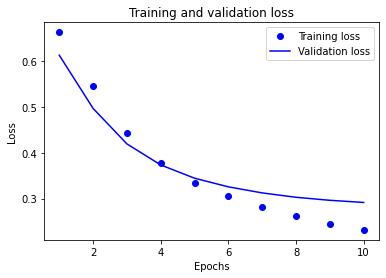

In [27]:
plt.style.use('seaborn')

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

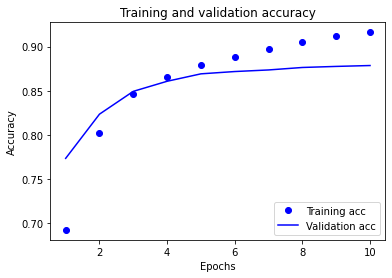

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

En este gráfico, los puntos representan la pérdida y la precisión del entrenamiento, y las líneas continuas son la pérdida y la precisión de la validación.

Observe que la pérdida de entrenamiento disminuye con cada época y la precisión del entrenamiento aumenta con cada época. Esto se espera cuando se usa una optimización de descenso de gradiente; debe minimizar la cantidad deseada en cada iteración.

Este no es el caso de la pérdida de validación y la precisión; parecen alcanzar su punto máximo antes que la precisión del entrenamiento. Este es un ejemplo de sobreajuste: el modelo funciona mejor en los datos de entrenamiento que en los datos que nunca antes había visto. Después de este punto, el modelo sobreoptimiza y aprende representaciones específicas de los datos de entrenamiento que no se generalizan a los datos de prueba.

Para este caso particular, podría evitar el sobreajuste simplemente deteniendo el entrenamiento cuando la precisión de la validación ya no aumente. Una forma de hacerlo es utilizar la [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=es-419) llamada [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=es-419).

### Exportar el modelo

En el código anterior, aplicó la capa `TextVectorization` al conjunto de datos antes de alimentar texto al modelo. Si desea que su modelo sea capaz de procesar cadenas sin procesar (por ejemplo, para simplificar su implementación), puede incluir la capa `TextVectorization` dentro de su modelo. Para hacerlo, puede crear un nuevo modelo utilizando los pesos que acaba de entrenar.

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.3058 - accuracy: 0.8756
0.8738800287246704


### Inferencia sobre nuevos datos

Para obtener predicciones para nuevos ejemplos, simplemente puede llamar `model.predict()`.

In [34]:
examples = [
  "The movie was great!",
  "The movie was a bit of a drama but this is not good movie. For me it is bad.",
  "The movie was terrible..."
]

results = export_model.predict(examples)

np.round(results)

array([[1.],
       [0.],
       [0.]], dtype=float32)

Ahora, un punto importante es empaquetar el modelo entrenado y descargarlo, por lo que puedes utilizar la funciónd e guardado que está en TensorFlow:

In [47]:
# Save model in tf format
export_model.save_weights('models/checkpoint', save_format='tf')
print('Model saved to disk.')

Model saved to disk.


Puedes probar el modelo guardado al cargarlo como un nuevo modelo.

In [48]:
new_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

new_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

new_model.load_weights('models/checkpoint')

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3102 - accuracy: 0.8739
0.8738800287246704


In [49]:
results = export_model.predict(examples)
np.round(results)

array([[1.],
       [0.],
       [0.]], dtype=float32)

### Descarga del modelo

Para nuestro caso, resultará útil poder comprimir los archivos generados para descargarlos a nuestro entorno local.

In [50]:
shutil.make_archive('models', 'zip', 'models')

'/content/models.zip'